# Analyse des Annonces de **Location** Immobilière — Mubawab (ALL)

Ce notebook réalise une **analyse exploratoire (EDA)** des annonces de location nettoyées, à partir du fichier :

- `../data/clean_data/mubawab_location_all_clean.csv`

Variables analysées (identiques au fichier propre) :

**id, ville, prix, surface, quartier, type_bien, nb_chambres, nb_salle_de_bain, url_annonce**

> Objectif : comprendre la répartition des annonces (par ville, type de bien…), étudier les distributions des prix/surfaces, et dériver des indicateurs comme le **prix au m²**.


## 1) Imports & chemins

- On charge les librairies
- On définit les chemins de lecture/écriture
- On crée un dossier pour sauvegarder les graphiques


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optionnel : affichage plus lisible
pd.set_option("display.max_columns", 50)

# =========================
# Chemins du projet (relatifs au dossier /notebooks)
# =========================
CLEAN_PATH = Path("..") / "data" / "clean_data" / "mubawab_location_all_clean.csv"

# Dossier de sortie pour tes figures
FIG_DIR = Path("..") / "visualisation descriptive" / "location_mubawab_graphique"
FIG_DIR.mkdir(parents=True, exist_ok=True)

print("CSV clean:", CLEAN_PATH.resolve())
print("Figures:", FIG_DIR.resolve())
assert CLEAN_PATH.exists(), "❌ Fichier introuvable: mubawab_location_all_clean.csv"


CSV clean: C:\Users\Si soufiane\Desktop\a\analyse-des-tendances-immobili-res-\data\clean_data\mubawab_location_all_clean.csv
Figures: C:\Users\Si soufiane\Desktop\a\analyse-des-tendances-immobili-res-\visualisation descriptive\location_mubawab_graphique


## 2) Chargement & vérification initiale

On charge le CSV propre, puis on vérifie :
- dimensions (lignes/colonnes)
- types des colonnes
- exemples de lignes


In [2]:
df = pd.read_csv(CLEAN_PATH, encoding="utf-8-sig")

print("Dimensions:", df.shape)
display(df.head(5))

print("\nTypes des colonnes:")
display(df.dtypes)


Dimensions: (3191, 9)


,id,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce
0,1,Casablanca,5800.0,130.0,Val Fleury à Casablanca,Appartement,3,2,https://www.mubawab.ma/fr/a/8279130/appartemen...
1,3,Casablanca,7300.0,63.0,Oulfa à Casablanca,Appartement,1,1,https://www.mubawab.ma/fr/a/8277563/studio-meu...
2,4,Casablanca,7500.0,71.0,Maârif à Casablanca,Appartement,2,1,https://www.mubawab.ma/fr/a/8281617/appartemen...
3,6,Casablanca,9500.0,115.0,Palmier à Casablanca,Appartement,3,2,https://www.mubawab.ma/fr/a/8052585/appartemen...
4,7,Casablanca,100001000.0,120.0,Oasis à Casablanca,Appartement,1,2,https://www.mubawab.ma/fr/a/8279252/louez-cet-...



Types des colonnes:


id                    int64
ville                object
prix                float64
surface             float64
quartier             object
type_bien            object
nb_chambres           int64
nb_salle_de_bain      int64
url_annonce          object
dtype: object

## 3) Contrôles de qualité (NA, doublons, valeurs aberrantes simples)

- Compter les valeurs manquantes
- Vérifier les doublons sur `url_annonce`
- Voir quelques valeurs min/max sur les variables numériques


In [3]:
# Valeurs manquantes
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts)

# Doublons URL
dup_url = df.duplicated(subset=["url_annonce"]).sum() if "url_annonce" in df.columns else 0
print("Doublons (url_annonce):", dup_url)

# Statistiques rapides (si numériques)
num_cols = [c for c in ["prix","surface","nb_chambres","nb_salle_de_bain"] if c in df.columns]
display(df[num_cols].describe(include="all"))


id                  0
ville               0
prix                0
surface             0
quartier            0
type_bien           0
nb_chambres         0
nb_salle_de_bain    0
url_annonce         0
dtype: int64

Doublons (url_annonce): 0


,prix,surface,nb_chambres,nb_salle_de_bain
count,3.191000e+03,3191.000000,3191.000000,3191.000000
mean,1.517628e+06,304.174705,2.451583,2.101222
std,1.726073e+07,3648.076967,1.217978,1.113371
min,2.200000e+02,10.000000,1.000000,1.000000
25%,8.000000e+03,75.000000,2.000000,1.000000
50%,1.200000e+04,110.000000,2.000000,2.000000
75%,2.100000e+04,180.000000,3.000000,3.000000
max,4.000050e+08,148148.000000,13.000000,11.000000


## 4) Nettoyage léger pour l'EDA (robuste)

Même si le fichier est déjà propre, on fait une petite préparation pour analyser :
- forcer `prix` et `surface` en float (si jamais)
- forcer `nb_chambres` et `nb_salle_de_bain` en int quand possible
- retirer les lignes avec prix/surface négatifs (si présents)


In [4]:
df_eda = df.copy()

# Cast robustes
for col in ["prix", "surface"]:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")

for col in ["nb_chambres", "nb_salle_de_bain"]:
    if col in df_eda.columns:
        df_eda[col] = pd.to_numeric(df_eda[col], errors="coerce")

# Nettoyage de base : valeurs impossibles
if "prix" in df_eda.columns:
    df_eda.loc[df_eda["prix"] <= 0, "prix"] = np.nan
if "surface" in df_eda.columns:
    df_eda.loc[df_eda["surface"] <= 0, "surface"] = np.nan

print("Après préparation EDA — NA prix:", df_eda["prix"].isna().sum(), "| NA surface:", df_eda["surface"].isna().sum())
display(df_eda.head(3))


Après préparation EDA — NA prix: 0 | NA surface: 0


,id,ville,prix,surface,quartier,type_bien,nb_chambres,nb_salle_de_bain,url_annonce
0,1,Casablanca,5800.0,130.0,Val Fleury à Casablanca,Appartement,3,2,https://www.mubawab.ma/fr/a/8279130/appartemen...
1,3,Casablanca,7300.0,63.0,Oulfa à Casablanca,Appartement,1,1,https://www.mubawab.ma/fr/a/8277563/studio-meu...
2,4,Casablanca,7500.0,71.0,Maârif à Casablanca,Appartement,2,1,https://www.mubawab.ma/fr/a/8281617/appartemen...


## 5) Répartition des annonces par ville

- Nombre d'annonces par ville
- Part (%) par ville


,nb_annonces,part_%
ville,,
Casablanca,1587,49.73
Marrakech,710,22.25
Rabat,523,16.39
Tanger,371,11.63


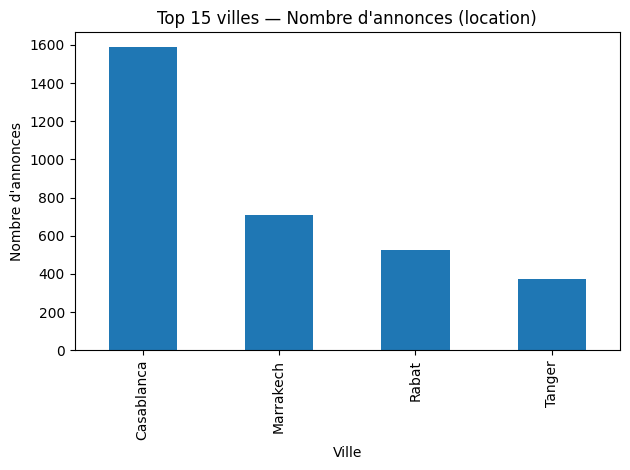

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\01_top_villes_nb_annonces.png


In [5]:
if "ville" in df_eda.columns:
    counts_ville = df_eda["ville"].fillna("Inconnu").value_counts()
    shares_ville = (counts_ville / len(df_eda) * 100).round(2)

    display(pd.DataFrame({"nb_annonces": counts_ville, "part_%": shares_ville}))

    # Graphique
    plt.figure()
    counts_ville.head(15).plot(kind="bar")
    plt.title("Top 15 villes — Nombre d'annonces (location)")
    plt.xlabel("Ville")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "01_top_villes_nb_annonces.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)
else:
    print("Colonne 'ville' introuvable.")


## 6) Répartition par type de bien

On observe quels types dominent (Appartement, Villa, Maison, etc.).


type_bien
Appartement    2639
Villa           528
Maison           21
Riad              2
Ferme             1
Name: count, dtype: int64

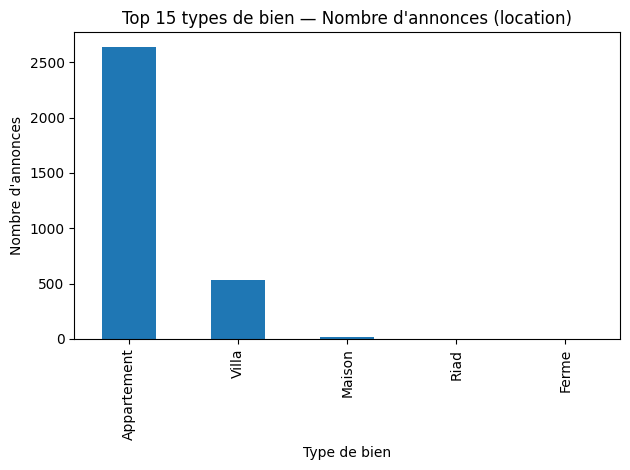

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\02_top_types_nb_annonces.png


In [6]:
if "type_bien" in df_eda.columns:
    counts_type = df_eda["type_bien"].fillna("Inconnu").value_counts()
    display(counts_type)

    plt.figure()
    counts_type.head(15).plot(kind="bar")
    plt.title("Top 15 types de bien — Nombre d'annonces (location)")
    plt.xlabel("Type de bien")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "02_top_types_nb_annonces.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)
else:
    print("Colonne 'type_bien' introuvable.")


## 7) Distribution des prix (location)

On visualise :
- histogramme global
- et la distribution des prix par ville (Top 8 villes) via un boxplot (après filtrage des extrêmes).


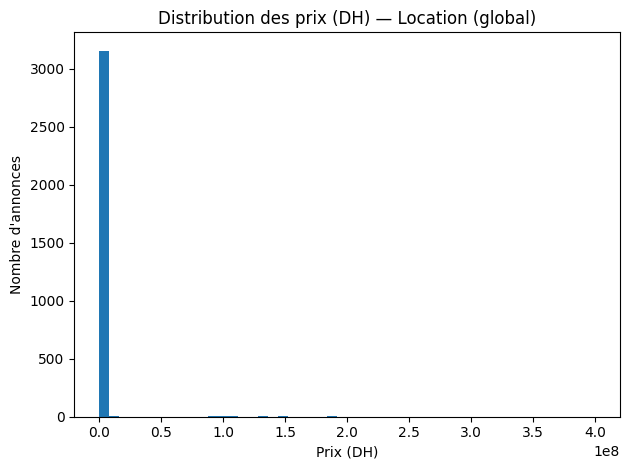

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\03_hist_prix_global.png


C:\Users\Si soufiane\AppData\Local\Temp\ipykernel_18108\6309915.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_villes, showfliers=False)


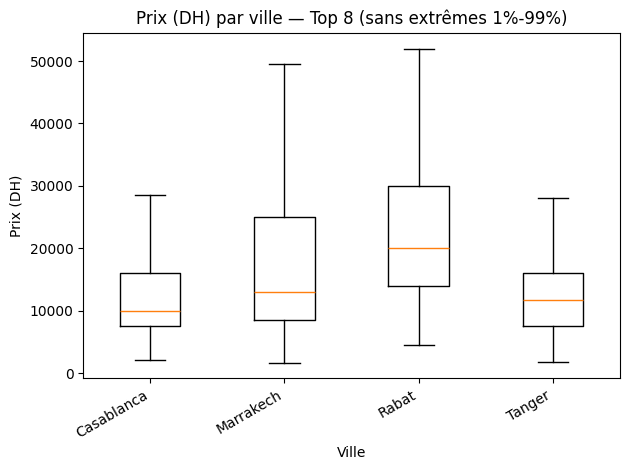

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\04_box_prix_par_ville.png


In [7]:
if "prix" in df_eda.columns:
    prix = df_eda["prix"].dropna()

    # Histogramme
    plt.figure()
    plt.hist(prix, bins=50)
    plt.title("Distribution des prix (DH) — Location (global)")
    plt.xlabel("Prix (DH)")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "03_hist_prix_global.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

    # Filtrer extrêmes pour boxplot lisible (ex: 1% - 99%)
    q1, q99 = prix.quantile(0.01), prix.quantile(0.99)
    df_box = df_eda[df_eda["prix"].between(q1, q99)].copy()

    # Top villes
    top_villes = df_box["ville"].value_counts().head(8).index.tolist()
    df_box = df_box[df_box["ville"].isin(top_villes)]

    # Boxplot "manuel" avec matplotlib
    data = [df_box.loc[df_box["ville"] == v, "prix"].dropna().values for v in top_villes]

    plt.figure()
    plt.boxplot(data, labels=top_villes, showfliers=False)
    plt.title("Prix (DH) par ville — Top 8 (sans extrêmes 1%-99%)")
    plt.xlabel("Ville")
    plt.ylabel("Prix (DH)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    out = FIG_DIR / "04_box_prix_par_ville.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

else:
    print("Colonne 'prix' introuvable.")


## 8) Distribution des surfaces

Même logique :
- histogramme global
- boxplot surfaces par ville (Top 8) en coupant les extrêmes pour lisibilité.


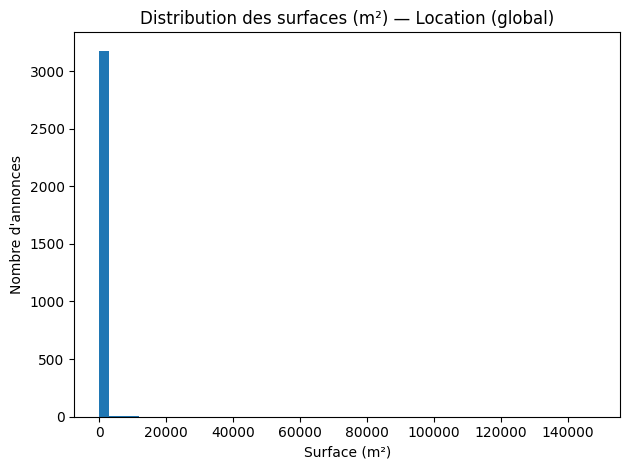

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\05_hist_surface_global.png


C:\Users\Si soufiane\AppData\Local\Temp\ipykernel_18108\601029070.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_villes, showfliers=False)


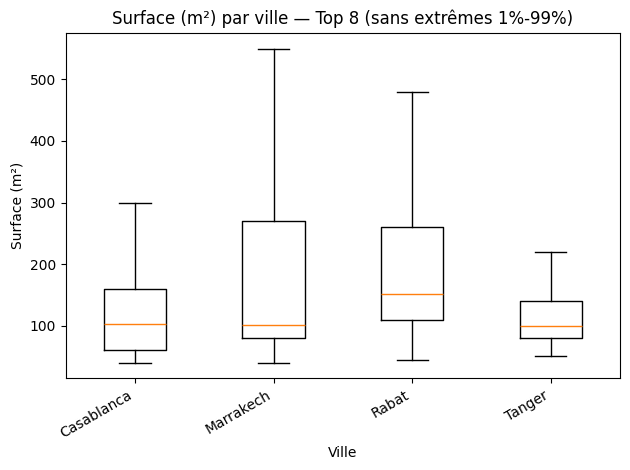

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\06_box_surface_par_ville.png


In [8]:
if "surface" in df_eda.columns:
    surf = df_eda["surface"].dropna()

    plt.figure()
    plt.hist(surf, bins=50)
    plt.title("Distribution des surfaces (m²) — Location (global)")
    plt.xlabel("Surface (m²)")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "05_hist_surface_global.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

    # Filtrer extrêmes pour boxplot lisible
    q1, q99 = surf.quantile(0.01), surf.quantile(0.99)
    df_box = df_eda[df_eda["surface"].between(q1, q99)].copy()

    top_villes = df_box["ville"].value_counts().head(8).index.tolist()
    df_box = df_box[df_box["ville"].isin(top_villes)]

    data = [df_box.loc[df_box["ville"] == v, "surface"].dropna().values for v in top_villes]

    plt.figure()
    plt.boxplot(data, labels=top_villes, showfliers=False)
    plt.title("Surface (m²) par ville — Top 8 (sans extrêmes 1%-99%)")
    plt.xlabel("Ville")
    plt.ylabel("Surface (m²)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    out = FIG_DIR / "06_box_surface_par_ville.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

else:
    print("Colonne 'surface' introuvable.")


## 9) Prix au m² (indicateur clé)

On calcule :

\[
prix\_m2 = \frac{prix}{surface}
\]

Puis on analyse :
- histogramme global
- prix/m² médian par ville (Top 10)


Nb lignes avec prix_m2 valide: 3191


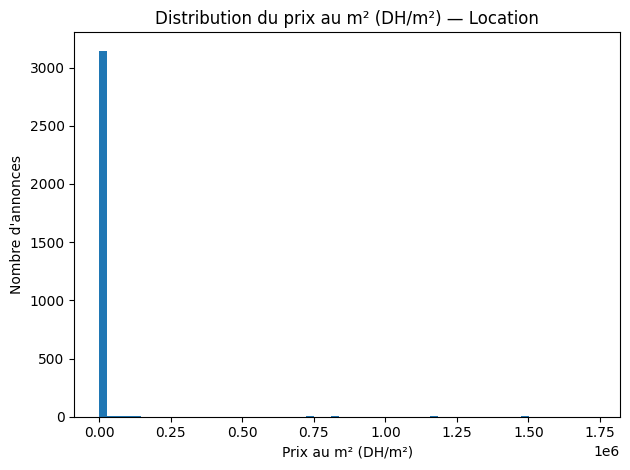

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\07_hist_prix_m2.png


ville
Rabat         111.111111
Casablanca    108.695652
Marrakech     102.830441
Tanger         92.307692
Name: prix_m2, dtype: float64

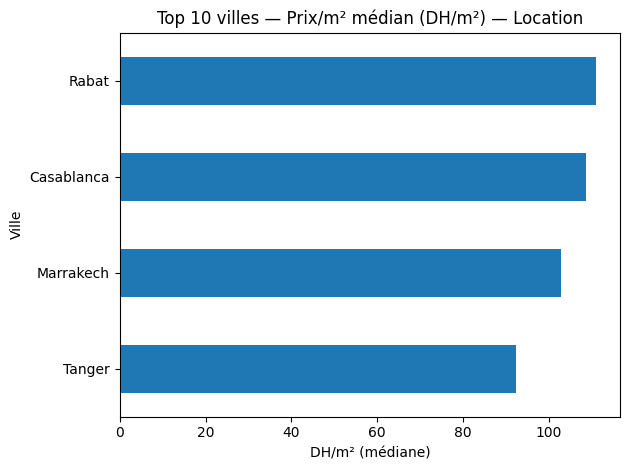

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\08_top10_villes_prix_m2_median.png


In [9]:
if ("prix" in df_eda.columns) and ("surface" in df_eda.columns):
    df_pm2 = df_eda.copy()
    df_pm2["prix_m2"] = df_pm2["prix"] / df_pm2["surface"]

    # Garder uniquement les valeurs valides
    df_pm2 = df_pm2.replace([np.inf, -np.inf], np.nan)
    df_pm2 = df_pm2[df_pm2["prix_m2"].notna()].copy()

    print("Nb lignes avec prix_m2 valide:", len(df_pm2))

    # Histogramme
    plt.figure()
    plt.hist(df_pm2["prix_m2"], bins=60)
    plt.title("Distribution du prix au m² (DH/m²) — Location")
    plt.xlabel("Prix au m² (DH/m²)")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "07_hist_prix_m2.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

    # Médiane par ville (Top 10)
    med_ville = df_pm2.groupby("ville")["prix_m2"].median().sort_values(ascending=False)
    display(med_ville.head(10))

    plt.figure()
    med_ville.head(10).sort_values().plot(kind="barh")
    plt.title("Top 10 villes — Prix/m² médian (DH/m²) — Location")
    plt.xlabel("DH/m² (médiane)")
    plt.ylabel("Ville")
    plt.tight_layout()
    out = FIG_DIR / "08_top10_villes_prix_m2_median.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

else:
    print("Colonnes 'prix' et/ou 'surface' introuvables.")


## 10) Chambres & salles de bain

On analyse :
- distribution du nombre de chambres
- distribution du nombre de salles de bain
- prix moyen (ou médian) selon le nombre de chambres


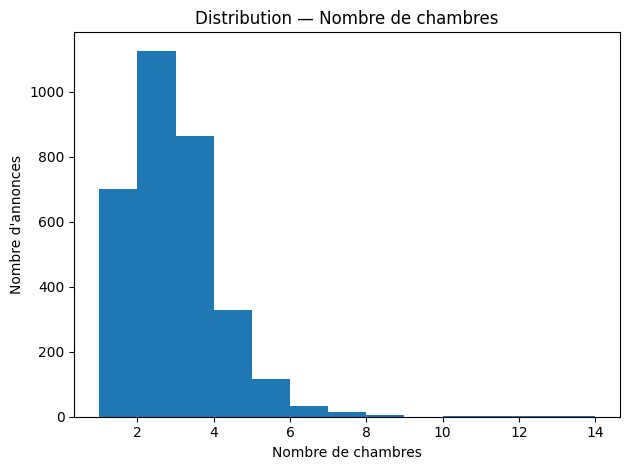

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\09_hist_nb_chambres.png


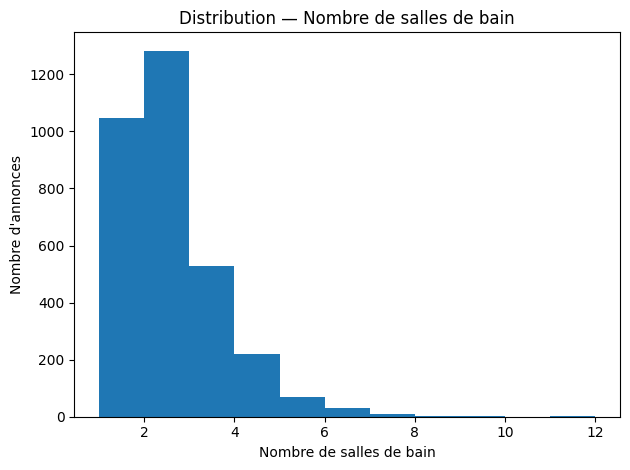

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\10_hist_nb_sdb.png


nb_chambres
1       7900.0
2      11000.0
3      16000.0
4      33000.0
5      45000.0
6      50000.0
7      38000.0
8      30000.0
10     95000.0
11      1800.0
12     80000.0
13    180000.0
Name: prix, dtype: float64

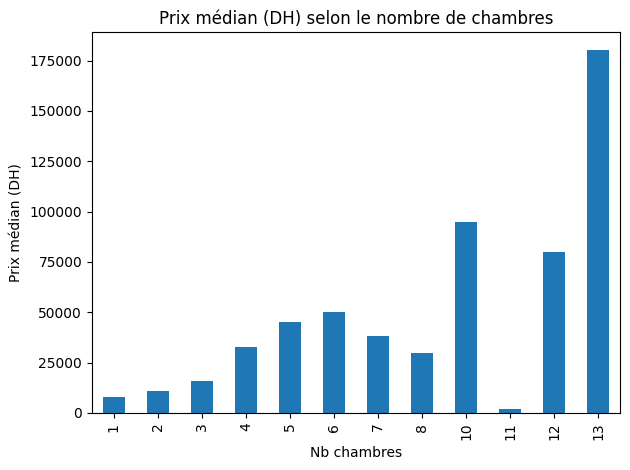

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\11_prix_median_par_nb_chambres.png


In [10]:
if "nb_chambres" in df_eda.columns:
    chambres = df_eda["nb_chambres"].dropna()

    plt.figure()
    plt.hist(chambres, bins=range(int(chambres.min()), int(chambres.max()) + 2))
    plt.title("Distribution — Nombre de chambres")
    plt.xlabel("Nombre de chambres")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "09_hist_nb_chambres.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

if "nb_salle_de_bain" in df_eda.columns:
    bains = df_eda["nb_salle_de_bain"].dropna()

    plt.figure()
    plt.hist(bains, bins=range(int(bains.min()), int(bains.max()) + 2))
    plt.title("Distribution — Nombre de salles de bain")
    plt.xlabel("Nombre de salles de bain")
    plt.ylabel("Nombre d'annonces")
    plt.tight_layout()
    out = FIG_DIR / "10_hist_nb_sdb.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

# Prix vs nb_chambres (médiane)
if ("prix" in df_eda.columns) and ("nb_chambres" in df_eda.columns):
    tmp = df_eda.dropna(subset=["prix", "nb_chambres"]).copy()
    med = tmp.groupby("nb_chambres")["prix"].median().sort_index()
    display(med)

    plt.figure()
    med.plot(kind="bar")
    plt.title("Prix médian (DH) selon le nombre de chambres")
    plt.xlabel("Nb chambres")
    plt.ylabel("Prix médian (DH)")
    plt.tight_layout()
    out = FIG_DIR / "11_prix_median_par_nb_chambres.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)


## 11) Relation prix vs surface (scatter)

On visualise la relation `prix` ↔ `surface`.
Pour éviter que quelques extrêmes écrasent le graphique, on filtre sur les quantiles 1%-99%.


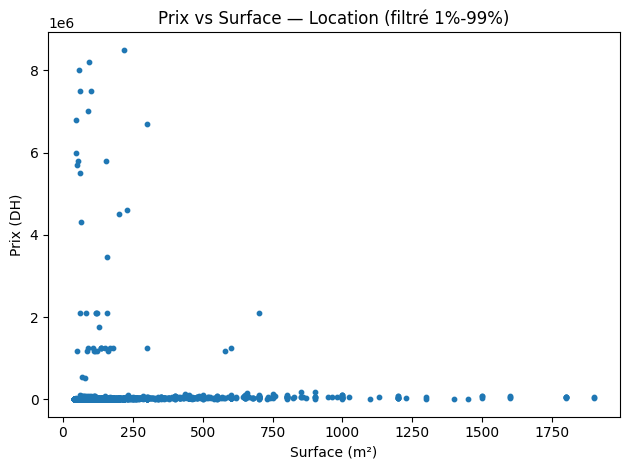

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\12_scatter_prix_vs_surface.png
Corrélation (prix, surface) sur échantillon filtré: -0.001


In [ ]:
if ("prix" in df_eda.columns) and ("surface" in df_eda.columns):
    tmp = df_eda.dropna(subset=["prix","surface"]).copy()

    qprix1, qprix99 = tmp["prix"].quantile(0.01), tmp["prix"].quantile(0.99)
    qsurf1, qsurf99 = tmp["surface"].quantile(0.01), tmp["surface"].quantile(0.99)

    tmp = tmp[tmp["prix"].between(qprix1, qprix99) & tmp["surface"].between(qsurf1, qsurf99)]

    plt.figure()
    plt.scatter(tmp["surface"], tmp["prix"], s=10)
    plt.title("Prix vs Surface — Location (filtré 1%-99%)")
    plt.xlabel("Surface (m²)")
    plt.ylabel("Prix (DH)")
    plt.tight_layout()
    out = FIG_DIR / "12_scatter_prix_vs_surface.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)

    # Corrélation
    corr = tmp[["prix","surface"]].corr().iloc[0,1]
    print("Corrélation (prix, surface) sur échantillon filtré:", round(float(corr), 3))


## 12) Quartiers les plus fréquents (Top 20)

Utile pour voir où les annonces se concentrent 


quartier
Casablanca Finance City à Casablanca        218
Souissi à Rabat                             174
Riyad à Rabat                               151
Racine à Casablanca                         128
Ain Diab à Casablanca                       124
Guéliz à Marrakech                          116
Gauthier à Casablanca                       105
Agdal à Marrakech                            94
Agdal à Rabat                                94
Les princesses à Casablanca                  90
Bourgogne Ouest à Casablanca                 75
Oasis à Casablanca                           72
Palmier à Casablanca                         68
Maârif à Casablanca                          67
Route Casablanca à Marrakech                 63
Ferme Bretonne (Hay Arraha) à Casablanca     62
De La Plage à Tanger                         59
Californie à Casablanca                      51
Centre à Tanger                              49
Hivernage à Marrakech                        49
Name: count, dtype: int64

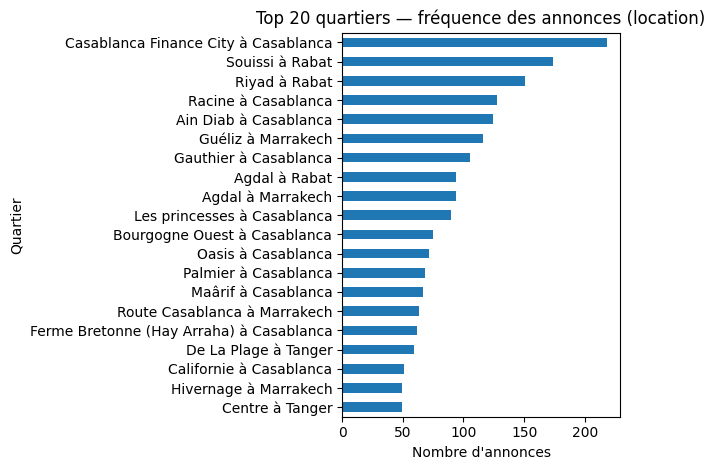

✅ Figure: ..\visualisation descriptive\location_mubawab_graphique\13_top20_quartiers.png


In [12]:
if "quartier" in df_eda.columns:
    top_q = df_eda["quartier"].fillna("Inconnu").value_counts().head(20)
    display(top_q)

    plt.figure()
    top_q.sort_values().plot(kind="barh")
    plt.title("Top 20 quartiers — fréquence des annonces (location)")
    plt.xlabel("Nombre d'annonces")
    plt.ylabel("Quartier")
    plt.tight_layout()
    out = FIG_DIR / "13_top20_quartiers.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("✅ Figure:", out)


## 13) Résumé & pistes d'analyse (interprétation)

À ce stade, tu peux enrichir ton rapport avec :
- **Top villes** par volume d'annonces
- **Fourchettes de prix** (médiane, Q1/Q3) par ville et par type
- **Prix/m²** médian pour comparer les marchés
- Influence des **chambres** sur le prix
- Comparaison **Appartement vs Villa** (prix, surface, prix/m²)

